In [1]:
import time
import torch
import sys
import os

project_path = os.path.abspath(os.path.join(os.getcwd(), '..', ''))
sys.path.append(project_path)

from python.create_dgl_dataset import TelemacDataset

from modulus.launch.utils import load_checkpoint, save_checkpoint
from python.CustomMeshGraphNet import MeshGraphNet
#from python.CustomMeshGraphNetDoubleEncoder import MeshGraphNet


In [2]:
from hydra.utils import to_absolute_path

In [3]:
dataset = TelemacDataset(
            name="telemac_train",
            data_dir=to_absolute_path('./data/TetQ2500inter_1min_chunk/TetQ2500inter_1min_multimesh_base.bin'),
            dynamic_data_file= to_absolute_path('./data/TetQ2500inter_1min_chunk/TetQ2500inter_1min_0_500-1000.pkl'),
            split="train",
            num_samples=1,
            num_steps=400,
            stride=20
        )

{'h': tensor([1.1066]), 'u': tensor([0.4942]), 'v': tensor([0.1065]), 'strickler': tensor([20.6628]), 'z': tensor([17.5927]), 'delta_h': tensor([0.0337]), 'delta_u': tensor([0.0138]), 'delta_v': tensor([0.0038]), 'h_std': tensor([1.9816]), 'u_std': tensor([0.9927]), 'v_std': tensor([0.4107]), 'strickler_std': tensor([11.6977]), 'z_std': tensor([13.9988]), 'delta_h_std': tensor([0.0747]), 'delta_u_std': tensor([0.0471]), 'delta_v_std': tensor([0.0317])}
{'xrel': tensor([0.]), 'yrel': tensor([0.]), 'norm': tensor([15.7447]), 'xrel_std': tensor([15.7152]), 'yrel_std': tensor([15.7621]), 'norm_std': tensor([15.7327])}
strickler
z
xrel
yrel
norm


In [4]:
model = MeshGraphNet(
            9,
            3,
            3,
            processor_size=12,
            hidden_dim_processor=64,
            hidden_dim_node_encoder=64,
            hidden_dim_edge_encoder=64,
            hidden_dim_node_decoder=64,
            do_concat_trick=True
        )

In [41]:
model.to('cuda')

MeshGraphNet(
  (edge_encoder): MeshGraphMLP(
    (model): Sequential(
      (0): Linear(in_features=3, out_features=64, bias=True)
      (1): SELU()
      (2): Linear(in_features=64, out_features=64, bias=True)
      (3): SELU()
      (4): Linear(in_features=64, out_features=64, bias=True)
      (5): FusedLayerNorm(torch.Size([64]), eps=1e-05, elementwise_affine=True)
    )
  )
  (node_encoder): MeshGraphMLP(
    (model): Sequential(
      (0): Linear(in_features=9, out_features=64, bias=True)
      (1): SELU()
      (2): Linear(in_features=64, out_features=64, bias=True)
      (3): SELU()
      (4): Linear(in_features=64, out_features=64, bias=True)
      (5): FusedLayerNorm(torch.Size([64]), eps=1e-05, elementwise_affine=True)
    )
  )
  (node_decoder): MeshGraphMLP(
    (model): Sequential(
      (0): Linear(in_features=64, out_features=64, bias=True)
      (1): SELU()
      (2): Linear(in_features=64, out_features=64, bias=True)
      (3): SELU()
      (4): Linear(in_features=64,

In [42]:
load_checkpoint(to_absolute_path("./jupyter"),model)

[15:55:25 - checkpoint - INFO] Loaded model state dictionary /users/daml/vmercier/gnn_modulus_project/jupyter/MeshGraphNet.0.1980.mdlus to device cpu
[15:55:25 - checkpoint - INFO] Loaded checkpoint file /users/daml/vmercier/gnn_modulus_project/jupyter/checkpoint.0.1980.pt to device cpu


1980

In [45]:
ts = 10
with torch.no_grad():
    pred = model(dataset[ts].ndata['x'].to('cuda'),dataset[0].edata['x'].to('cuda'),dataset[0].to('cuda')).cpu().numpy()
groundtruth = dataset[ts].ndata['y'].numpy()

In [31]:
from python.create_dgl_dataset import add_mesh_info
from python.python_code.data_manip.extraction.telemac_file import TelemacFile

import dgl
graphs, _ = dgl.load_graphs('./data/TetQ2500inter_1min_chunk/TetQ2500inter_1min_base.bin') 
mesh_list = ['/projets/aniti-daml/vmercier/simu_valentin/maillage_3.slf']
res_mesh = TelemacFile(mesh_list[0])
X,triangles = add_mesh_info(res_mesh)

In [32]:
import numpy as np 

In [33]:
h_max = max(np.max(groundtruth[:,0]),np.max(pred[:,0]))
h_min = min(np.min(groundtruth[:,0]),np.min(pred[:,0]))

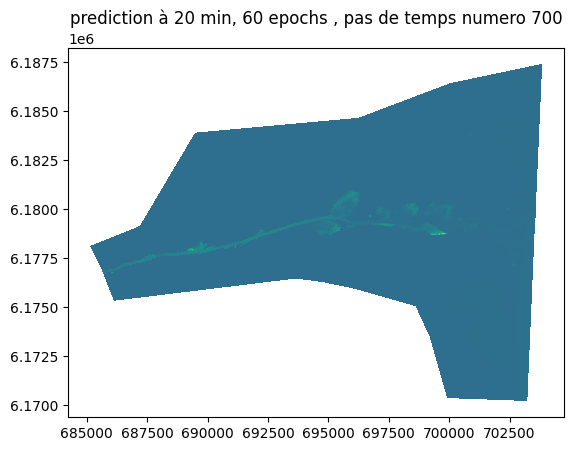

In [34]:
import matplotlib.pyplot as plt
plt.figure()
plt.title('prediction à 20 min, 60 epochs , pas de temps numero {}'.format(500+ts*20))
plt.tripcolor(X[:,0],X[:,1],pred[:,0],triangles=triangles,vmax=h_max,vmin=h_min)
#plt.xlim(685000,687500)
#plt.ylim(6170000,6180000)
plt.show()

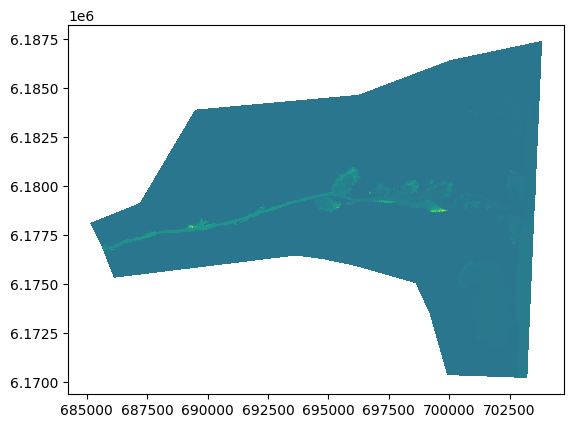

In [35]:
plt.figure()
plt.tripcolor(X[:,0],X[:,1],groundtruth[:,0],triangles=triangles)#,vmax=h_max,vmin=h_min)
#plt.xlim(685000,687500)
#plt.ylim(6170000,6180000)
plt.show()

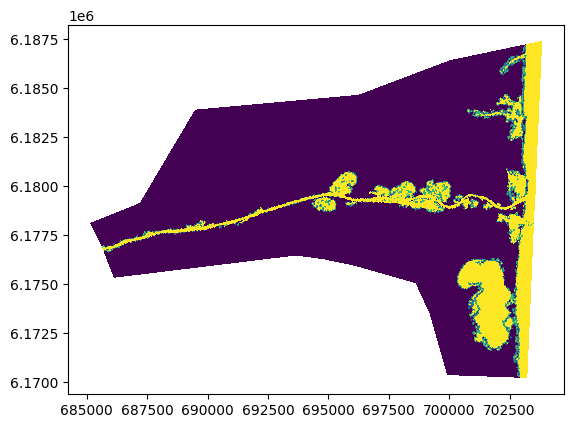

In [39]:
plt.figure()
plt.tripcolor(X[:,0],X[:,1],dataset[ts].ndata['x'][:,6]>0.0,triangles=triangles)
plt.show()

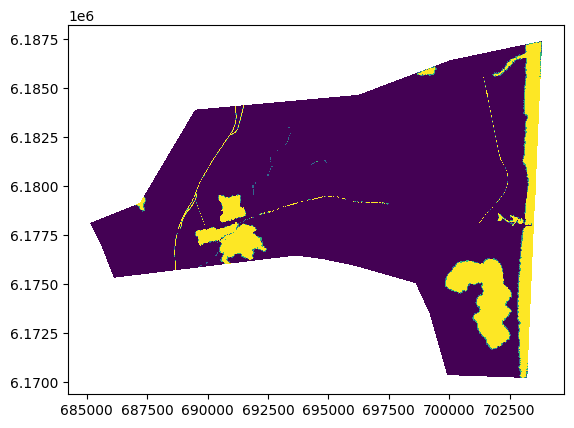

In [13]:
plt.figure()
plt.tripcolor(X[:,0],X[:,1],np.abs(dataset[ts].ndata['x'][:,4])>1.0,triangles=triangles)
plt.show()

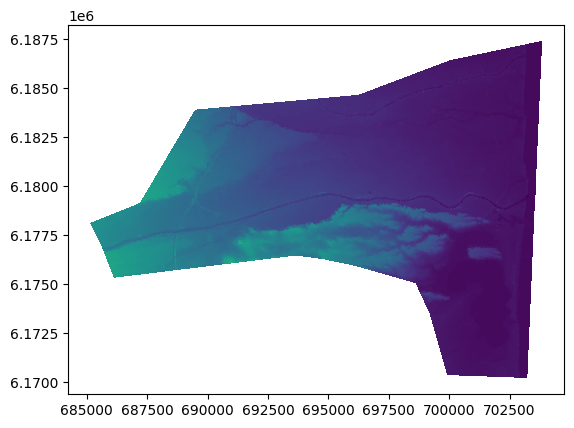

In [14]:
plt.figure()
plt.tripcolor(X[:,0],X[:,1],dataset[ts].ndata['x'][:,5],triangles=triangles)
plt.show()

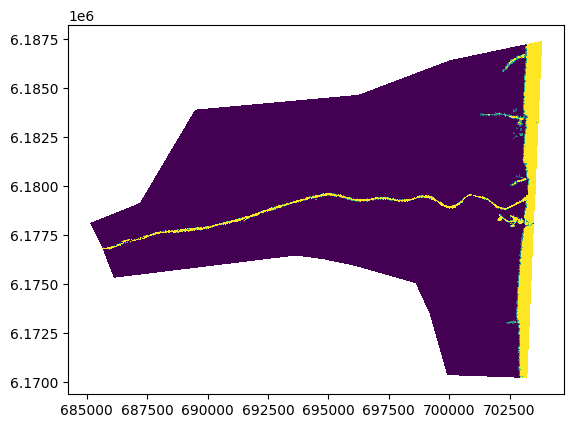

In [15]:
plt.figure()
plt.tripcolor(X[:,0],X[:,1],np.abs(dataset[ts].ndata['x'][:,6])>1.0,triangles=triangles)
plt.show()

In [16]:
print(np.max(np.abs(dataset[ts].ndata['x'][:,4].numpy())))

3.362817


In [59]:
dataset_test = TelemacDataset(
            name="telemac_train",
            data_dir=to_absolute_path('./data/TetQ2500inter_1min_chunk/TetQ2500inter_1min_multimesh_base.bin'),
            dynamic_data_file= to_absolute_path('./data/TetQ2500inter_1min_chunk/TetQ2500inter_1min_0_500-1000.pkl'),
            split="train",
            num_samples=1,
            num_steps=500,
            stride=20,
            normalize=False
        )

In [66]:
print(dataset.node_stats)

AttributeError: 'TelemacDataset' object has no attribute 'node_stats'

In [65]:
node_stats = dataset._get_node_stats(dataset.node_var_info)
edge_stats = dataset._get_edge_stats(dataset.edge_var_info)
print(node_stats)
dataset_test._normalize_data(node_stats, edge_stats, dataset_test.node_var_info, dataset_test.edge_var_info)

{'h': tensor([1.1066]), 'u': tensor([0.4942]), 'v': tensor([0.1065]), 'strickler': tensor([-4.4944e-08]), 'z': tensor([-2.0816e-07]), 'delta_h': tensor([0.0337]), 'delta_u': tensor([0.0138]), 'delta_v': tensor([0.0038]), 'h_std': tensor([1.9816]), 'u_std': tensor([0.9927]), 'v_std': tensor([0.4107]), 'strickler_std': tensor([1.]), 'z_std': tensor([1.0000]), 'delta_h_std': tensor([0.0747]), 'delta_u_std': tensor([0.0471]), 'delta_v_std': tensor([0.0317])}
strickler
z
xrel
yrel
norm


In [63]:
Mse = torch.nn.MSELoss()
Mae = torch.nn.L1Loss()
variable = 0
for ts in range(len(dataset_test)):
    with torch.no_grad():
        pred = model(dataset_test[ts].ndata['x'].to('cuda'),dataset_test[0].edata['x'].to('cuda'),dataset_test[0].to('cuda')).cpu()
    groundtruth = dataset_test[ts].ndata['y']
    print("______ ts : {} __________".format(ts))
    print(Mse(pred[:,0],groundtruth[:,0]).item())
    print(Mae(pred[:,0],groundtruth[:,0]).item())

______ ts : 0 __________
0.0017368532717227936
0.02838541939854622
______ ts : 1 __________
0.0013553815660998225
0.026015739887952805
______ ts : 2 __________
0.001603183918632567
0.027071895077824593
______ ts : 3 __________
0.0023821524810045958
0.03147916495800018
______ ts : 4 __________
0.0030416357330977917
0.0363599918782711
______ ts : 5 __________
0.005037594120949507
0.04549601674079895
______ ts : 6 __________
0.008303679525852203
0.0564984530210495
______ ts : 7 __________
0.010243604891002178
0.0617670901119709
______ ts : 8 __________
0.009595820680260658
0.05809707194566727
______ ts : 9 __________
0.008913839235901833
0.05369735136628151
______ ts : 10 __________
0.00793551281094551
0.05030078813433647
______ ts : 11 __________
0.0057482342235744
0.04316170513629913
______ ts : 12 __________
0.004020614083856344
0.03272309899330139
______ ts : 13 __________
0.0038311309181153774
0.03364314138889313
______ ts : 14 __________
0.005398076493293047
0.03719313442707062
____

In [64]:
for ts in range(len(dataset)):
    with torch.no_grad():
        pred = model(dataset[ts].ndata['x'].to('cuda'),dataset[0].edata['x'].to('cuda'),dataset[0].to('cuda')).cpu()
    groundtruth = dataset[ts].ndata['y']
    print("______ ts : {} __________".format(ts))
    print(Mse(pred[:,0],groundtruth[:,0]).item())
    print(Mae(pred[:,0],groundtruth[:,0]).item())

______ ts : 0 __________
0.0004146834253333509
0.01561010256409645
______ ts : 1 __________
0.0002493474748916924
0.013552283868193626
______ ts : 2 __________
0.0003518036683090031
0.014921700581908226
______ ts : 3 __________
0.0006405561580322683
0.01793082244694233
______ ts : 4 __________
0.0007009634864516556
0.018376454710960388
______ ts : 5 __________
0.0007241324638016522
0.01909285970032215
______ ts : 6 __________
0.0009519780869595706
0.021259520202875137
______ ts : 7 __________
0.0011207069037482142
0.02247522957623005
______ ts : 8 __________
0.0009171142592094839
0.02063708007335663
______ ts : 9 __________
0.0006894962280057371
0.018449079245328903
______ ts : 10 __________
0.0006111797410994768
0.01700340397655964
______ ts : 11 __________
0.0009407713660039008
0.017683299258351326
______ ts : 12 __________
0.0007198958192020655
0.017792746424674988
______ ts : 13 __________
0.0006785665755160153
0.015703096985816956
______ ts : 14 __________
0.0006156540475785732
0.